# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2 as cv
from glob import glob
import pandas as pd

In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [4]:
DIR = '../input/ocular-disease-recognition-odir5k'

full_df = pd.read_csv(f'{DIR}/full_df.csv', index_col=0)

full_df.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
ID,,,,,,,,,,,,,,,,,,
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Data Preprocessing

In [5]:
full_df['side'] = full_df['filename'].str[:-4].str.replace(r'\d+_', '', regex=True)

In [6]:
image_dir = '../input/ocular-disease-recognition-odir5k/ODIR-5K/'
full_df['filepath'] = full_df['filepath'].str.replace(image_dir, image_dir + 'ODIR-5K/')

In [7]:
age_intervals = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81+']
full_df['Age Group'] = pd.cut(full_df['Patient Age'], bins=age_intervals, labels=age_labels, right=False)

In [8]:
full_df['labels_text'] = full_df['labels'].apply(lambda x: x[2])
full_df['target'] = np.where(full_df['labels_text'] == "A", 1, 0)

# Split Dataset

In [9]:
right_df = full_df[full_df['side'] == 'right']
left_df = full_df[full_df['side'] == 'left']

# Fix data imbalance

right_df_0 = right_df[right_df['target'] == 0]
right_df_0 = right_df_0.sample(frac=0.25, random_state=42)
right_df_1 = right_df[right_df['target'] == 1]

left_df_0 = left_df[left_df['target'] == 0]
left_df_0 = left_df_0.sample(frac=0.25, random_state=42)
left_df_1 = left_df[left_df['target'] == 1]

right_df = pd.concat([right_df_0, right_df_1])
left_df = pd.concat([left_df_0, left_df_1])

right_df = right_df.sample(frac=1, random_state=42)
left_df = left_df.sample(frac=1, random_state=42)

right_train, right_test = train_test_split(right_df, test_size=0.2, random_state=42)
left_train, left_test = train_test_split(left_df, test_size=0.2, random_state=42)

train_df = pd.concat([right_train, left_train])
valid_df = pd.concat([right_test, left_test])

# Prepare Dataset and Dataloader

In [10]:
class EyeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406),
                       (0.229, 0.224, 0.225))
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filepath = self.df.iloc[idx]['filepath']
        image = cv.imread(filepath)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, thresholded = cv.threshold(image, 0, 255, cv.THRESH_OTSU)
        x, y, w, h = cv.boundingRect(thresholded)
        cropped_image = cv.cvtColor(image[y:y+h, x:x+w], cv.COLOR_GRAY2RGB)
        cropped_image = Image.fromarray(cropped_image)
        target = self.df.iloc[idx]['target']
        
        return cropped_image, target
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        targets = targets.to(device)
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        ).to(device)
        return imgs, targets

In [11]:
train_ds = EyeDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)

valid_ds = EyeDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=64,
                      collate_fn=valid_ds.collate_fn)

In [12]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))

Size of Train: 1436
Size of Validation: 361


# Model

In [13]:
class EyeClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
classifier = EyeClassifier(pretrained=True)
_ = summary(classifier, torch.ones(1,3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 175MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 28, 28] 

# Define Train and Validate Functions

In [15]:
def crop_image(image):
    _, thresholded = cv.threshold(image, 0, 255, cv.THRESH_OTSU)
    x, y, w, h = cv.boundingRect(thresholded)
    return image[y:y+h, x:x+w]

In [16]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall_score

In [17]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall_score

# Training Model

In [18]:
classifier = EyeClassifier(pretrained=True).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                      gamma=0.25)
best_recall_score = 0
n_epochs = 15
xticks = list(i+1 for i in range(n_epochs))

In [19]:
mem = {
    'train_loss': [],
    'train_recall_score': [],
    'valid_loss': [],
    'valid_recall_score': []
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recall_scores = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall_score = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recall_scores.append(train_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall score:', "%.3f" % train_recall_score, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall_score'].append(np.mean(train_recall_scores))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recall_scores = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall_score = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recall_scores.append(valid_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall score:', "%.3f" % valid_recall_score, 
            end='\r'
        )
    
    cur_recall_score = np.mean(valid_recall_scores)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall_score'].append(cur_recall_score)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall score:', "%.3f" % mem['train_recall_score'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall score:', "%.3f" % mem['valid_recall_score'][-1],
    )
    
    if best_recall_score < cur_recall_score:
        best_recall_score = cur_recall_score
        torch.save(classifier.state_dict(), './saved_model/amd_state_dict.pth')
        torch.save(classifier, './saved_model/amd_model.pth')
        
    scheduler.step()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.674 	train recall score: 0.617 	valid loss: 0.440 	valid recall score: 0.899
epoch: 2 	train loss: 0.417 	train recall score: 0.834 	valid loss: 0.625 	valid recall score: 0.857
epoch: 3 	train loss: 0.215 	train recall score: 0.972 	valid loss: 0.633 	valid recall score: 0.860
epoch: 4 	train loss: 0.135 	train recall score: 0.984 	valid loss: 0.426 	valid recall score: 0.945
epoch: 5 	train loss: 0.097 	train recall score: 0.994 	valid loss: 0.638 	valid recall score: 0.949
epoch: 6 	train loss: 0.075 	train recall score: 0.998 	valid loss: 0.369 	valid recall score: 0.970
epoch: 7 	train loss: 0.066 	train recall score: 0.997 	valid loss: 0.409 	valid recall score: 0.955
epoch: 8 	train loss: 0.050 	train recall score: 0.998 	valid loss: 0.383 	valid recall score: 0.967
epoch: 9 	train loss: 0.056 	train recall score: 0.999 	valid loss: 0.636 	valid recall score: 0.955
epoch: 10 	train loss: 0.051 	train recall score: 0.998 	valid loss: 0.647 	valid recall sc

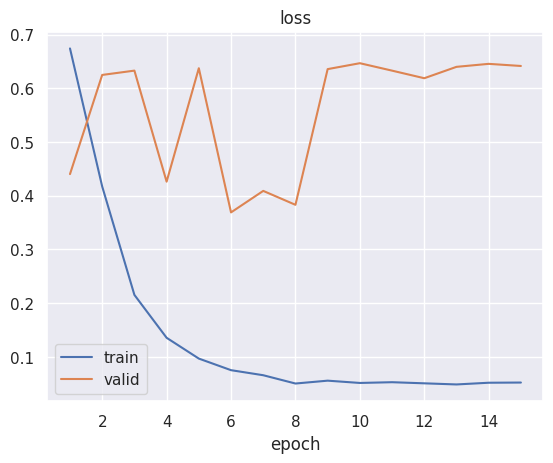

In [20]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

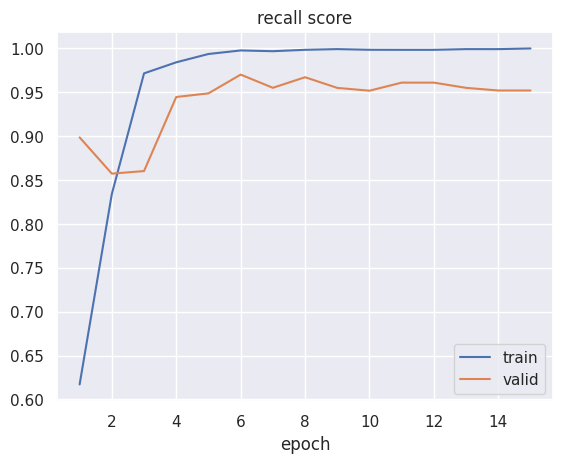

In [21]:
plt.plot(xticks, mem['train_recall_score'])
plt.plot(xticks, mem['valid_recall_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()